In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


In [3]:
path1='C:/Users/Prishat/Desktop/project-2/binarization/Original'
path2='C:/Users/Prishat/Desktop/project-2/binarization/Marked'

In [4]:
def get_imlist(path):
    return [os.path.join(f) for f in os.listdir(path) if f.endswith('.jpg')]

In [5]:
height=128
width=128
chanels=1

In [6]:
Original_list=get_imlist(path1)
Marked_list=get_imlist(path2)

Original=np.array([np.array(Image.open(path1+'\\'+im).convert('L').resize((128,128))) for im in Original_list])
Marked=np.array([np.array(Image.open(path2+'\\'+im).convert('L').resize((128,128))) for im in Marked_list])//255

In [7]:
Original_=Original[...,None]
Marked_=Marked[...,None]
m,n,j,g=Marked_.shape[0:4]
m,n,j,g

(497, 128, 128, 1)

In [11]:
l=int(m*0.9)

im_test=Original[l:]
im_test=im_test[...,None]

im_train=Original[:l]
im_train=im_train[...,None]

te_lab=Marked[l:]
te_lab=te_lab[...,None]

tr_lab=Marked[:l]
tr_lab=tr_lab[...,None]
print(im_test.shape)
print(im_train.shape)
print(te_lab.shape)
print(tr_lab.shape)

(50, 128, 128, 1)
(447, 128, 128, 1)
(50, 128, 128, 1)
(447, 128, 128, 1)


In [12]:
x=Input(shape=(height,width,chanels))
inp=x

conv1= Conv2D(16,(3,3),activation='elu',padding='same')(inp)
conv1=Dropout(0.1)(conv1)
conv1= Conv2D(16,(3,3),activation='elu',padding='same')(conv1)
p1=MaxPooling2D((2,2))(conv1)

conv2= Conv2D(32,(3,3),activation='elu',padding='same')(p1)
conv2=Dropout(0.1)(conv2)
conv2= Conv2D(32,(3,3),activation='elu',padding='same')(conv2)
p2= MaxPooling2D((2,2))(conv2)

conv3= Conv2D(64,(3,3),activation='elu',padding='same')(p2)
conv3=Dropout(0.2)(conv3)
conv3= Conv2D(64,(3,3),activation='elu',padding='same')(conv3)
p3= MaxPooling2D((2,2))(conv3)

conv4= Conv2D(128,(3,3),activation='elu',padding='same')(p3)
conv4=Dropout(0.2)(conv4)
conv4= Conv2D(128,(3,3),activation='elu',padding='same')(conv4)
p4= MaxPooling2D((2,2))(conv4)

conv5= Conv2D(256,(3,3),activation='elu',padding='same')(p4)
conv5=Dropout(0.3)(conv5)
conv5= Conv2D(256,(3,3),activation='elu',padding='same')(conv5)

up1=Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(conv5)
up1= concatenate([up1,conv4])
conv6= Conv2D(128,(3,3),activation='elu',padding='same')(up1)
conv6=Dropout(0.2)(conv6)
conv6= Conv2D(128,(3,3),activation='elu',padding='same')(conv6)

up2=Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(conv6)
up2= concatenate([up2,conv3])
conv7= Conv2D(64,(3,3),activation='elu',padding='same')(up2)
conv7=Dropout(0.2)(conv7)
conv7= Conv2D(64,(3,3),activation='elu',padding='same')(conv7)

up3=Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(conv7)
up3= concatenate([up3,conv2])
conv8= Conv2D(32,(3,3),activation='elu',padding='same')(up3)
conv8=Dropout(0.1)(conv8)
conv8= Conv2D(32,(3,3),activation='elu',padding='same')(conv8)

up4=Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(conv8)
up4= concatenate([up4,conv1])
conv9= Conv2D(16,(3,3),activation='elu',padding='same')(up4)
conv9=Dropout(0.1)(conv9)
conv9= Conv2D(16,(3,3),activation='elu',padding='same')(conv9)

out=Conv2D(1,(1,1),activation='sigmoid')(conv9)

model=Model(x,out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 128, 128, 16) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 16) 2320        dropout_10[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [13]:
earlystopper= EarlyStopping(patience=3)
checkpoint= ModelCheckpoint('UNet_model_2.h5',verbose=1,save_best_only=True)
history=model.fit(im_train,tr_lab,validation_split=0.1,batch_size=16,epochs=20,callbacks=[earlystopper,checkpoint])

Train on 402 samples, validate on 45 samples
Epoch 1/20
402/402 [==============================] - 141s 352ms/step - loss: 0.8720 - acc: 0.8078 - val_loss: 0.4221 - val_acc: 0.8341

Epoch 00001: val_loss improved from inf to 0.42214, saving model to UNet_model_2.h5
Epoch 2/20
402/402 [==============================] - 139s 345ms/step - loss: 0.3149 - acc: 0.8907 - val_loss: 0.3161 - val_acc: 0.8899

Epoch 00002: val_loss improved from 0.42214 to 0.31612, saving model to UNet_model_2.h5
Epoch 3/20
402/402 [==============================] - 139s 345ms/step - loss: 0.2700 - acc: 0.9144 - val_loss: 0.2802 - val_acc: 0.9104

Epoch 00003: val_loss improved from 0.31612 to 0.28021, saving model to UNet_model_2.h5
Epoch 4/20
402/402 [==============================] - 139s 345ms/step - loss: 0.2628 - acc: 0.9183 - val_loss: 0.2705 - val_acc: 0.9129

Epoch 00004: val_loss improved from 0.28021 to 0.27052, saving model to UNet_model_2.h5
Epoch 5/20
402/402 [==============================] - 139s 

In [2]:
model=load_model('UNet_model_2.h5')

In [13]:
tr=model.predict(im_test[0:10])
for k in tr:
    for i in range(len(k)):
        for j in range(len(k[0])):
            if k[i][j]>0.40:
                k[i][j]=1
            else:
                k[i][j]=0
           

In [14]:
tr=tr*255
tr

array([[[[255.],
         [  0.],
         [255.],
         ...,
         [255.],
         [255.],
         [255.]],

        [[255.],
         [255.],
         [255.],
         ...,
         [255.],
         [255.],
         [255.]],

        [[255.],
         [255.],
         [255.],
         ...,
         [255.],
         [255.],
         [255.]],

        ...,

        [[255.],
         [255.],
         [255.],
         ...,
         [255.],
         [255.],
         [255.]],

        [[255.],
         [255.],
         [255.],
         ...,
         [255.],
         [255.],
         [255.]],

        [[255.],
         [255.],
         [255.],
         ...,
         [255.],
         [255.],
         [255.]]],


       [[[255.],
         [  0.],
         [255.],
         ...,
         [255.],
         [255.],
         [255.]],

        [[255.],
         [255.],
         [255.],
         ...,
         [255.],
         [255.],
         [255.]],

        [[255.],
         [255.],
      

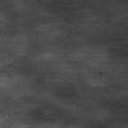

In [16]:
imo=np.array(im_test[])
imo=imo.reshape((128,128))
imo=Image.fromarray(imo)
#imo=imo.convert('RGB')
#imo.show()
imo

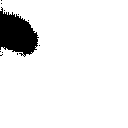

In [27]:
imp=np.array(tr[3])
imp=imp.reshape((128,128))
imp=Image.fromarray(imp)
imp=imp.convert('L')
#imp.show()
imp

In [23]:
model.evaluate(im_test,te_lab)

ValueError: Input arrays should have the same number of samples as target arrays. Found 106 input samples and 199 target samples.

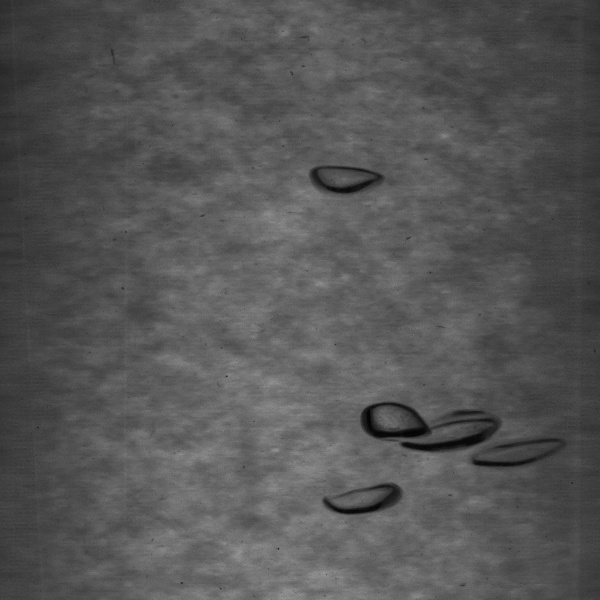

In [13]:
im=Image.open('a520.jpg').convert('L')
im

In [28]:
img=np.array(im.resize((128,128)))
img=img[...,None]
img=img[None,...]
img.shape

(1, 128, 128, 1)

In [29]:
p=model.predict(img)

In [19]:
for k in p:
    for i in range(len(k)):
        for j in range(len(k[0])):
            if k[i][j]>0.87:
                k[i][j]=1
            else:
                k[i][j]=0

In [35]:
p=p*255
p=p.reshape((128,128))
p.shape

(128, 128)

In [50]:
pi=np.array(p)
= p.astype(np.uint32)
#pi.reshape((128,128))
pi=Image.fromarray(pi)
pi.convert('L')
pi.save('n.png')

OSError: cannot write mode F as PNG